In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
# from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import re #Stopwords
import nltk #PortStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from kneed import KneeLocator

nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\johnw\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\johnw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\johnw\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Preprocessing

Combine -> preprocess -> shuffle

Shuffling the combined dataset for

Balanced distribution of classes: When you concatenate the two datasets (fake and true), you end up with all fake samples first, followed by all true samples. Shuffling the dataset ensures that you have a balanced and mixed distribution of both classes throughout the dataset. This is particularly important when you split the data into training and testing sets, as it helps to maintain a balanced class distribution in both subsets.

Reducing bias: Shuffling helps reduce the risk of introducing any potential biases that might be present in the order of the samples. If the samples are ordered in a certain way (e.g., by date, by author, or by topic), the model might learn patterns related to this order rather than the actual differences between fake and true news.

Improving model generalization: By shuffling the data, you ensure that the model is exposed to a variety of samples during training, which helps it learn to generalize better to unseen data. If the data is not shuffled, the model might overfit to specific patterns in the training data, which could hurt its performance on the test data.



In [16]:
fake_df = pd.read_csv('Fake.csv')
true_df = pd.read_csv('True.csv')

# Add labels to the datasets
fake_df['label'] = 0
true_df['label'] = 1

# Preprocess the text data
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text.lower())  # Remove non-word characters and convert to lowercase
    words = text.split()
    words = [WordNetLemmatizer().lemmatize(word) for word in words if word not in set(stopwords.words('english'))]  # Remove stopwords and lemmatize
    return ' '.join(words)

# Preprocess the text data for fake_df and true_df
fake_df['processed_text'] = fake_df['text'].apply(preprocess_text)
true_df['processed_text'] = true_df['text'].apply(preprocess_text)

# Combine the datasets
news_df = pd.concat([fake_df, true_df], ignore_index=True)

# Shuffle the combined dataset
news_df = news_df.sample(frac=1, random_state=42).reset_index(drop=True)

## Visualization: word cloud, class distribution, top frequent words by class

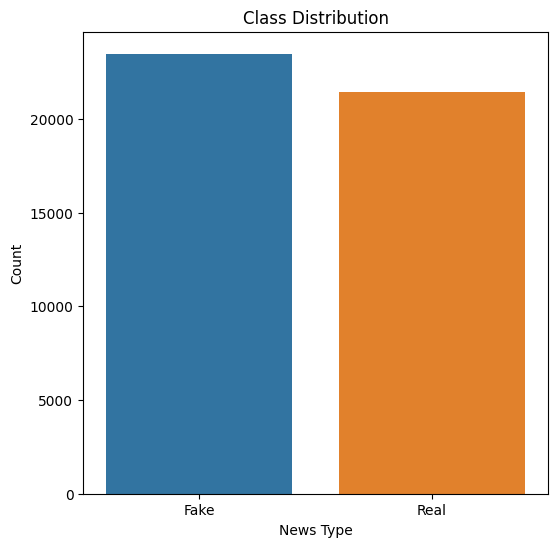

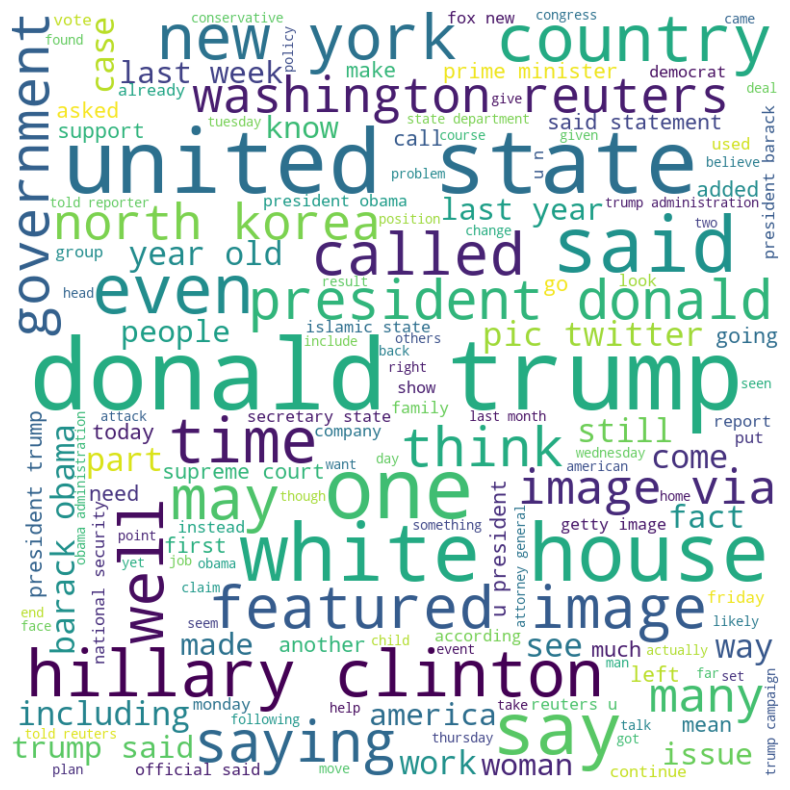

In [17]:
"""Visualize the class distribution"""
plt.figure(figsize=(6, 6))
sns.countplot(x='label', data=news_df)
plt.xlabel('News Type')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()

"""Word Cloud"""
# Combine all processed text
all_text = ' '.join(news_df['processed_text'].values)

# Generate a word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=150).generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



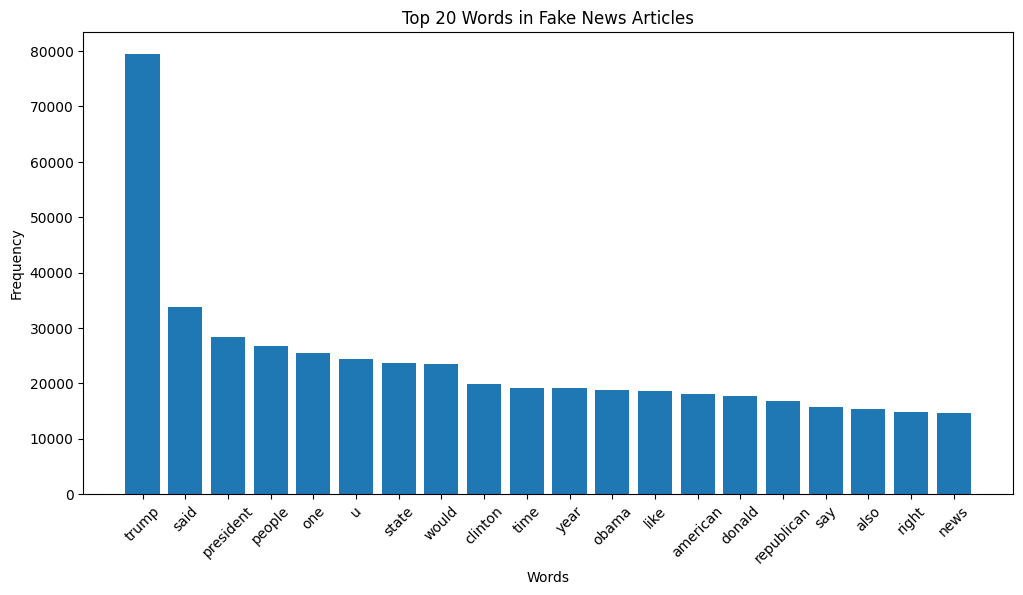

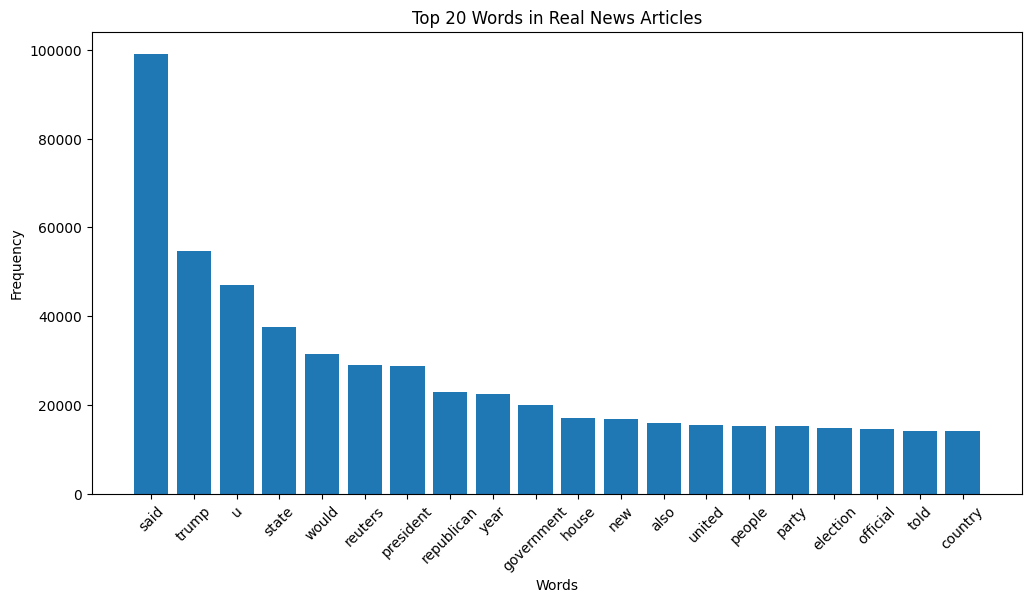

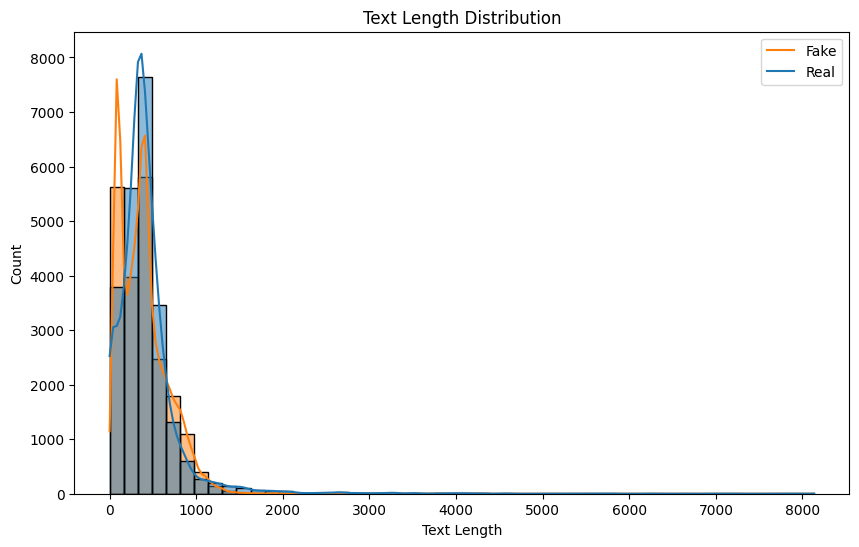

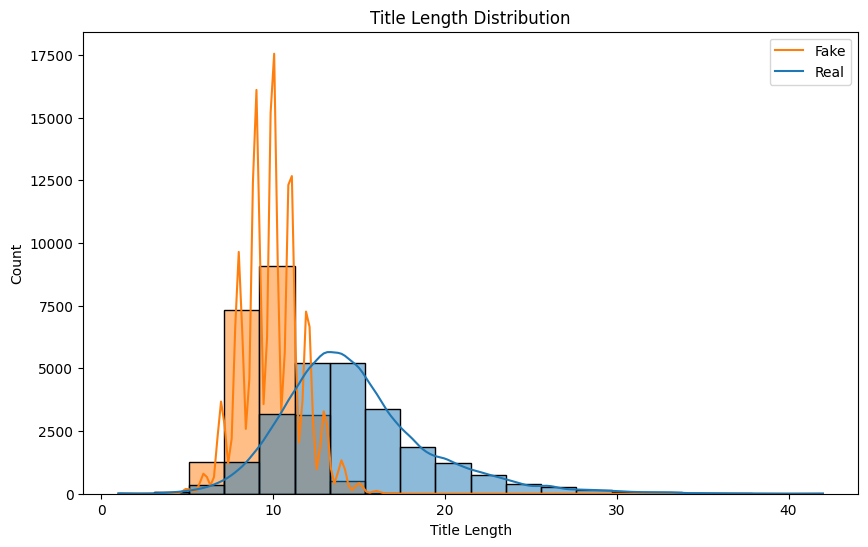

In [18]:
"""Top frequent words by class"""
def get_top_n_words(corpus, n=None):
    # Combine all texts in the corpus
    all_words = ' '.join(corpus).split()
    
    # Count the occurrences of each word
    word_freqs = Counter(all_words)
    
    # Get the n most common words
    top_n_words = word_freqs.most_common(n)
    
    return top_n_words

# Set the number of top words to display
n_top_words = 20

# Get the top 20 words for fake and real news separately
top_fake_words = get_top_n_words(fake_df['processed_text'], n_top_words)
top_real_words = get_top_n_words(true_df['processed_text'], n_top_words)

# New DataFrame for each class
fake_words_df = pd.DataFrame(top_fake_words, columns=['word', 'frequency'])
real_words_df = pd.DataFrame(top_real_words, columns=['word', 'frequency'])

# Plot the top words for fake news
plt.figure(figsize=(12, 6))
plt.bar(fake_words_df['word'], fake_words_df['frequency'])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top {} Words in Fake News Articles'.format(n_top_words))
plt.xticks(rotation=45)
plt.show()

# Plot the top words for real news
plt.figure(figsize=(12, 6))
plt.bar(real_words_df['word'], real_words_df['frequency'])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top {} Words in Real News Articles'.format(n_top_words))
plt.xticks(rotation=45)
plt.show()


"""Visualize text length distribution"""
# New column for text length
news_df['text_length'] = news_df['text'].apply(lambda x: len(x.split()))

# Plot the distribution of text lengths
plt.figure(figsize=(10, 6))
sns.histplot(data=news_df, x='text_length', hue='label', kde=True, bins=50)
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.title('Text Length Distribution')
plt.legend(labels=['Fake', 'Real'])
plt.show()

"""
Visualize title length distribution
"""
# Add a column for title length
news_df['title_length'] = news_df['title'].apply(lambda x: len(x.split()))

# Plot the distribution of title lengths
plt.figure(figsize=(10, 6))
sns.histplot(data=news_df, x='title_length', hue='label', kde=True, bins=20)
plt.xlabel('Title Length')
plt.ylabel('Count')
plt.title('Title Length Distribution')
plt.legend(labels=['Fake', 'Real'])
plt.show()

## Splitting the dataset into 60% train, 20% validation, and 20% test sets.

In [19]:
# Split the dataset into train and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(news_df['processed_text'], news_df['label'], test_size=0.2, random_state=42)

# Split the train set further into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2


## Convert text data into numerical format by TF-IDF

ref:https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe

In [20]:
vectorizer = TfidfVectorizer()

# Scale the training data and also learn the scaling parameters(mean and variance of the features) of that data
# Resulting X_train_tfidf is a matrix containing the TF-IDF values for each word in training set.
X_train_tfidf = vectorizer.fit_transform(X_train)

# For validation and test sets, use transform() instead to transform the sets
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

## Supervised learning: implement linear SVC and MultinomialNB 
ref:https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
https://medium.com/@manoveg/multi-class-text-classification-with-probability-prediction-for-each-class-using-linearsvc-in-289189fbb100

https://towardsdatascience.com/multinomial-na%C3%AFve-bayes-for-documents-classification-and-natural-language-processing-nlp-e08cc848ce6

LinearSVC vs. SVC:
LinearSVC uses one-vs-the-rest scheme, SVC uses one vs one scheme for multiclass handling

MultinomialNB is designed for discrete data, such as word counts or term frequencies in text data. It assumes that the features follow a multinomial distribution, which is a reasonable assumption when working with text data, as it represents the number of occurrences of each word or term. This makes MultinomialNB a suitable choice for text classification tasks.

In [23]:
# Create and fit the Naïve Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

# Predict on the validation set
y_val_pred_nb = nb_classifier.predict(X_val_tfidf)

# Calculate and print the accuracy
accuracy = accuracy_score(y_val, y_val_pred_nb)
print(f"Multinomial Naïve Bayes Accuracy: {accuracy}")

# Create and fit the Linear SVM classifier
svm_classifier = LinearSVC()
svm_classifier.fit(X_train_tfidf, y_train)

# Predict on the validation set
y_val_pred_svm = svm_classifier.predict(X_val_tfidf)

# Calculate and print the accuracy
accuracy = accuracy_score(y_val, y_val_pred_svm)
print(f"Linear SVM Accuracy: {accuracy}")


Multinomial Naïve Bayes Accuracy: 0.9351893095768374
Linear SVM Accuracy: 0.9925389755011136


## hyperparameter tuning for supervised models

Best Multinomial Naïve Bayes Parameters: {'alpha': 0.1}


C:\Users\johnw\anaconda3\envs\seem2460\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\johnw\anaconda3\envs\seem2460\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\johnw\anaconda3\envs\seem2460\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\johnw\anaconda3\envs\seem2460\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\johnw\anaconda3\envs\seem2460\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best Linear SVM Parameters: {'C': 10}
Tuned Multinomial Naïve Bayes Accuracy: 0.9394209354120268
Tuned Linear SVM Accuracy: 0.9932071269487751
Tuned Multinomial Naïve Bayes Evaluation Metrics:
Accuracy: 0.9394
Precision: 0.9458
Recall: 0.9259
F1 Score: 0.9358


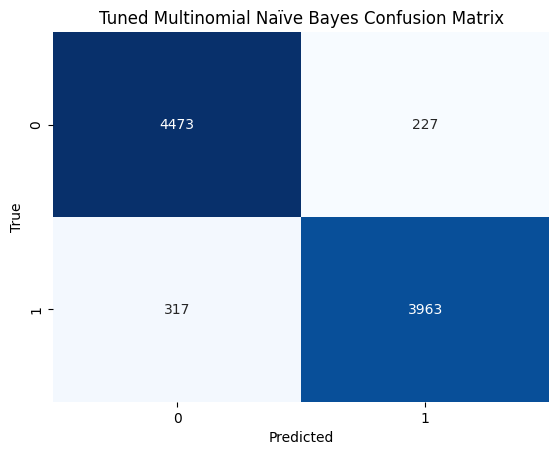

Tuned Linear SVM Evaluation Metrics:
Accuracy: 0.9932
Precision: 0.9923
Recall: 0.9935
F1 Score: 0.9929


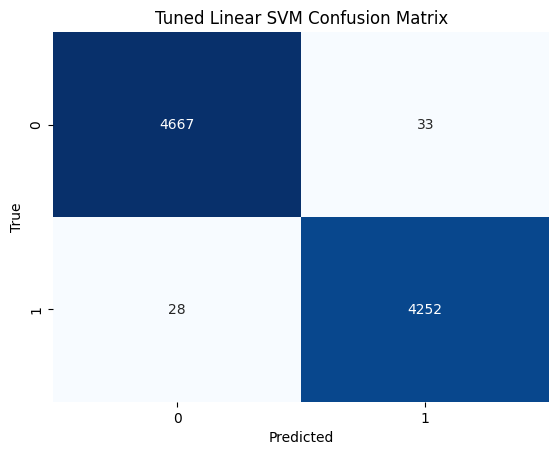

Best Model: Linear SVM


In [25]:
# NB hyperparameter tuning
nb_params = {'alpha': [0.1, 0.5, 1, 1.5, 2, 5]}
grid_nb = GridSearchCV(MultinomialNB(), nb_params, scoring='accuracy', cv=5)
grid_nb.fit(X_train_tfidf, y_train)

best_nb = grid_nb.best_estimator_
print(f"Best Multinomial Naïve Bayes Parameters: {grid_nb.best_params_}")

# LinearSVM hyperparameter tuning
svm_params = {'C': [0.1, 1, 10, 100]}
grid_svm = GridSearchCV(LinearSVC(), svm_params, scoring='accuracy', cv=5)
grid_svm.fit(X_train_tfidf, y_train)

best_svm = grid_svm.best_estimator_
print(f"Best Linear SVM Parameters: {grid_svm.best_params_}")

# Evaluate the tuned models on the validation set
y_val_pred_nb_tuned = best_nb.predict(X_val_tfidf)
y_val_pred_svm_tuned = best_svm.predict(X_val_tfidf)

# Calculate and print the accuracy
accuracy_nb_tuned = accuracy_score(y_val, y_val_pred_nb_tuned)
accuracy_svm_tuned = accuracy_score(y_val, y_val_pred_svm_tuned)
print(f"Tuned Multinomial Naïve Bayes Accuracy: {accuracy_nb_tuned}")
print(f"Tuned Linear SVM Accuracy: {accuracy_svm_tuned}")

def evaluate_display_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"{model_name} Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    return f1

# Evaluate the tuned models on the validation set
f1_nb_tuned = evaluate_display_metrics(y_val, y_val_pred_nb_tuned, "Tuned Multinomial Naïve Bayes")
f1_svm_tuned = evaluate_display_metrics(y_val, y_val_pred_svm_tuned, "Tuned Linear SVM")

# Select the best model based on F1 score
best_model = best_nb if f1_nb_tuned > f1_svm_tuned else best_svm
best_model_name = "Multinomial Naïve Bayes" if f1_nb_tuned > f1_svm_tuned else "Linear SVM"
print(f"Best Model: {best_model_name}")


## Unsupervised learning with K-means clustering

find the optimal number of clusters using the elbow method 

Choose the optimal number of clusters based on the elbow plot where the rate of decrease slows down 

using PCA for dimensionality reduction


In [28]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


# Determine the optimal number of clusters using the elbow method
distortions = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train_tfidf)
    distortions.append(kmeans.inertia_)

## Apply PCA to reduce the dimension into 2D to visualize the clusters in a 2D plot

ref for elbow point finding:https://stackoverflow.com/questions/51762514/find-the-elbow-point-on-an-optimization-curve-with-python


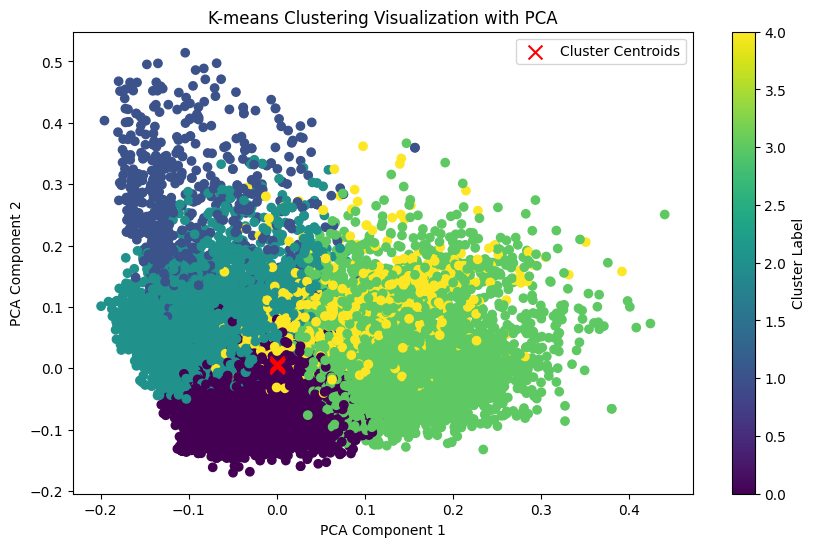

In [29]:
# Find the elbow point
kn = KneeLocator(K, distortions, curve='convex', direction='decreasing')
optimal_k = kn.elbow

# Apply K-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k)
kmeans.fit(X_train_tfidf)

# Visualize the clusters using PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())

plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=kmeans.labels_, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-means Clustering Visualization with PCA')
plt.colorbar().set_label('Cluster Label')

# Plot cluster centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='red', marker='x', label='Cluster Centroids')
plt.legend()
plt.show()


## Visualize most common terms in each cluster 

In [31]:
def get_top_features_cluster(tfidf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tfidf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names_out() 
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

top_features_per_cluster = get_top_features_cluster(X_train_tfidf.toarray(), kmeans.labels_, 20)

for i, df in enumerate(top_features_per_cluster):
    print(f"Cluster {i} Top Features:")
    print(df)
    print("\n")


Cluster 0 Top Features:
     features     score
0        said  0.021978
1     clinton  0.018182
2       trump  0.016694
3      people  0.016580
4       obama  0.015883
5      police  0.015142
6       state  0.014989
7     hillary  0.014167
8         one  0.014072
9        year  0.013683
10      woman  0.013338
11  president  0.013310
12      would  0.012007
13      right  0.011800
14       like  0.011724
15   american  0.011698
16       time  0.011244
17        law  0.011117
18      black  0.011006
19      video  0.010807


Cluster 1 Top Features:
     features     score
0       korea  0.258373
1       north  0.223389
2      korean  0.105685
3     nuclear  0.092241
4     missile  0.086180
5       china  0.076539
6       south  0.066453
7        said  0.061919
8   pyongyang  0.060932
9        test  0.049756
10   sanction  0.047233
11      trump  0.046160
12     united  0.045080
13      state  0.041308
14      japan  0.040025
15    beijing  0.033000
16        kim  0.032517
17    chinese 

#  <font color='red'>previous code !!! Remove later</font>

In [10]:
# Function to evaluate the models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred))
    print('Recall:', recall_score(y_test, y_pred))
    print('F1 Score:', f1_score(y_test, y_pred))
    print('Confusion Matrix:', confusion_matrix(y_test, y_pred))

# Create a hyperparameter grid for Logistic Regression
lr_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
# Create a hyperparameter grid for Support Vector Machines
svc_param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
# Create a hyperparameter grid for Naïve Bayes
nb_param_grid = {'alpha': [0.001, 0.01, 0.1, 0.5, 1, 1.5, 2, 5, 10]}    

# Instantiate the models
lr_model = LogisticRegression(max_iter=1000)
svc_model = SVC(max_iter=1000)
nb_model = MultinomialNB()

# Create GridSearchCV instances
lr_grid_search = GridSearchCV(lr_model, lr_param_grid, cv=5, scoring='accuracy')
svc_grid_search = GridSearchCV(svc_model, svc_param_grid, cv=5, scoring='accuracy')
nb_grid_search = GridSearchCV(nb_model, nb_param_grid, cv=5, scoring='accuracy')

# Perform the grid search for Logistic Regression
lr_grid_search.fit(X_train_tfidf, y_train)
# Perform the grid search for Support Vector Machines
svc_grid_search.fit(X_train_tfidf, y_train)
# Perform the grid search for Naïve Bayes
nb_grid_search.fit(X_train_tfidf, y_train)

# Print the best hyperparameters for Logistic Regression
print("Best parameters for Logistic Regression:", lr_grid_search.best_params_)
# Print the best hyperparameters for Support Vector Machines
print("Best parameters for Support Vector Machines:", svc_grid_search.best_params_)
# Print the best hyperparameters for Naïve Bayes
print("Best parameters for Naïve Bayes:", nb_grid_search.best_params_)



# Evaluate the best models on the validation set
print("\nEvaluating the best models on the validation set:")
print("\nLogistic Regression")
best_lr_model = lr_grid_search.best_estimator_
evaluate_model(best_lr_model, X_train_tfidf, X_val_tfidf, y_train, y_val)

print("\nSupport Vector Machines")
best_svc_model = svc_grid_search.best_estimator_
evaluate_model(best_svc_model, X_train_tfidf, X_val_tfidf, y_train, y_val)

print("\nNaïve Bayes")
best_nb_model = nb_grid_search.best_estimator_
evaluate_model(best_nb_model, X_train_tfidf, X_val_tfidf, y_train, y_val)

# Evaluate the best model (assume the best model is Logistic Regression) on the test set

# print("\nEvaluating the best model on the test set:")
# evaluate_model(best_lr_model, X_train_tfidf, X_test_tfidf, y_train, y_test)


    

    
# Logistic Regression
# print("Logistic Regression")
# lr_model = LogisticRegression()
# evaluate_model(lr_model, X_train_tfidf, X_test_tfidf, y_train, y_test)

# # Naïve Bayes
# print("\nNaïve Bayes")
# nb_model = MultinomialNB()
# evaluate_model(nb_model, X_train_tfidf, X_test_tfidf, y_train, y_test)

# # Support Vector Machines
# print("\nSupport Vector Machines")
# svc_model = SVC()
# evaluate_model(svc_model, X_train_tfidf, X_test_tfidf, y_train, y_test)


C:\Users\johnw\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\johnw\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\johnw\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\johnw\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\johnw\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1

Best parameters for Logistic Regression: {'C': 100}
Best parameters for Support Vector Machines: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best parameters for Naïve Bayes: {'alpha': 0.01}

Evaluating the best models on the validation set:

Logistic Regression
Accuracy: 0.9917594654788419
Precision: 0.9930635838150289
Recall: 0.9898594146116617
F1 Score: 0.9914589104339797
Confusion Matrix: [[4611   30]
 [  44 4295]]

Support Vector Machines


C:\Users\johnw\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 0.9924276169265034
Precision: 0.9930731932579081
Recall: 0.9912422217100715
F1 Score: 0.9921568627450981
Confusion Matrix: [[4611   30]
 [  38 4301]]

Naïve Bayes
Accuracy: 0.9439866369710468
Precision: 0.9500234631628344
Recall: 0.9331643235768611
F1 Score: 0.941518428089757
Confusion Matrix: [[4428  213]
 [ 290 4049]]


Evaluating Logistic Regression on the validation set:


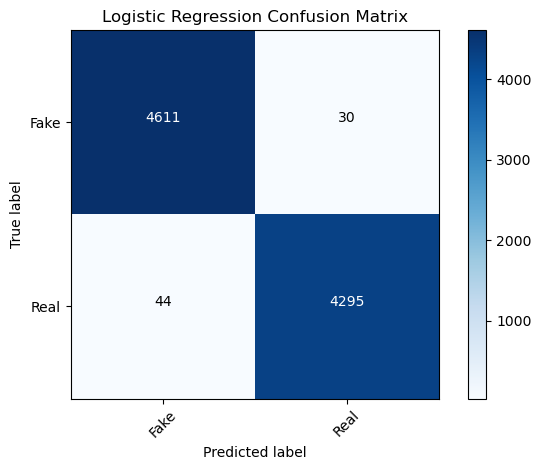

Evaluating Support Vector Machines on the validation set:


C:\Users\johnw\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


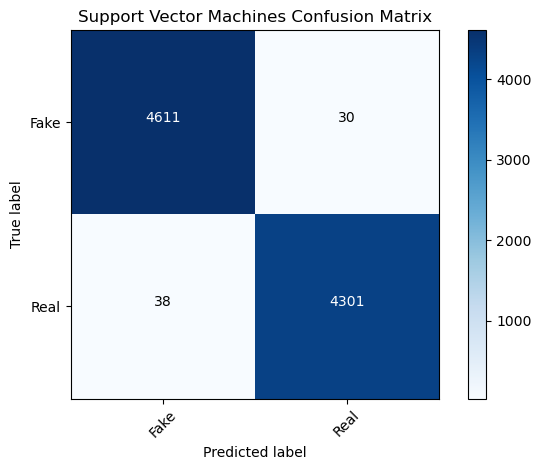

Evaluating Naïve Bayes on the validation set:


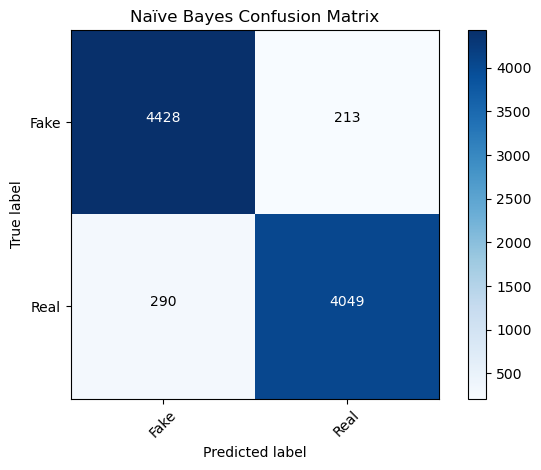

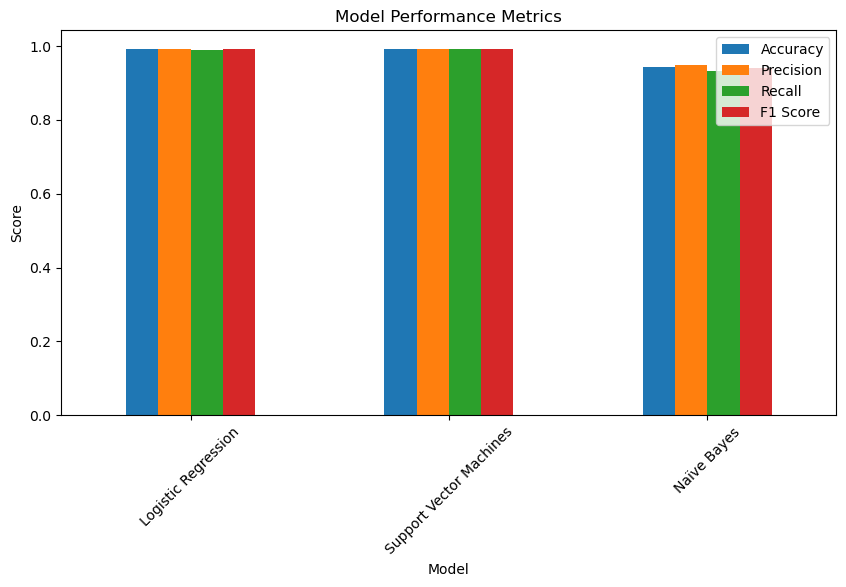

In [11]:
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def plot_model_performance(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=['Fake', 'Real'], title=f'{model_name} Confusion Matrix')
    plt.show()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return {'Model': model_name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

# Evaluate the best models on the validation set
best_models = [best_lr_model, best_svc_model, best_nb_model]
model_names = ['Logistic Regression', 'Support Vector Machines', 'Naïve Bayes']

performance_metrics = []
for model, model_name in zip(best_models, model_names):
    print(f"Evaluating {model_name} on the validation set:")
    metrics = plot_model_performance(model, X_train_tfidf, X_val_tfidf, y_train, y_val, model_name)
    performance_metrics.append(metrics)

# Create a DataFrame of model performance metrics
performance_df = pd.DataFrame(performance_metrics)

# Plot a bar chart of model performance metrics
performance_df.plot(x='Model', y=['Accuracy', 'Precision', 'Recall', 'F1 Score'], kind='bar', figsize=(10, 5))
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()

In [6]:
# Assuming Logistic Regression was the best-performing model
feature_names = np.array(CountVectorizer.get_feature_names_out())
sorted_coef_index = lr_model.coef_[0].argsort()

# Top 10 features for fake news
print('Top 10 features for fake news:')
print(feature_names[sorted_coef_index[:10]])

# Top 10 features for real news
print('\nTop 10 features for real news:')
print(feature_names[sorted_coef_index[-10:]])


TypeError: get_feature_names_out() missing 1 required positional argument: 'self'